In [ ]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns

from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

train_file_id = '1J6pVdmBbEN7kvAq6f36s9Nx7qFNVpjfD'
test_file_id = '1NnH_ZI6EbISZJO1YOLfmLs9ex11wO2AH'

train_download = drive.CreateFile({'id': train_file_id})
test_download = drive.CreateFile({'id': test_file_id})

# Download the file to a local disc
train_download.GetContentFile('train_file.csv')
test_download.GetContentFile('test_file.csv')


# Specify the data type for the problematic column (e.g., as 'str' if it should be a string)
# If you're not sure about the correct data type, you can use 'str' to read everything as strings and then process it later.
dtype_dict = {6: 'str'}

train_data = pd.read_csv("train_file.csv", dtype=dtype_dict, low_memory=False)
test_data = pd.read_csv("test_file.csv", dtype=dtype_dict, low_memory=False)


# Data preprocessing

In [ ]:
import pandas as pd
# Display basic information about the dataset
train_data_info = train_data.info()
train_data_head = train_data.head()

train_data_info, train_data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


(None,
   PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
 0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
 1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
 2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
 3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
 4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   
 
    RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
 0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
 1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
 2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
 3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
 4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   
 
    Transported  
 0        False  
 1         True  
 2        False  
 3        F

In [ ]:
# Checking for missing values and getting basic statistics
missing_values = train_data.isnull().sum()
basic_stats = train_data.describe(include='all')
target_distribution = train_data['Transported'].value_counts(normalize=True)

missing_values, basic_stats, target_distribution


(PassengerId       0
 HomePlanet      201
 CryoSleep       217
 Cabin           199
 Destination     182
 Age             179
 VIP             203
 RoomService     181
 FoodCourt       183
 ShoppingMall    208
 Spa             183
 VRDeck          188
 Name            200
 Transported       0
 dtype: int64,
        PassengerId HomePlanet CryoSleep    Cabin  Destination          Age  \
 count         8693       8492      8476     8494         8511  8514.000000   
 unique        8693          3         2     6560            3          NaN   
 top        0001_01      Earth     False  G/734/S  TRAPPIST-1e          NaN   
 freq             1       4602      5439        8         5915          NaN   
 mean           NaN        NaN       NaN      NaN          NaN    28.827930   
 std            NaN        NaN       NaN      NaN          NaN    14.489021   
 min            NaN        NaN       NaN      NaN          NaN     0.000000   
 25%            NaN        NaN       NaN      NaN          

In [ ]:
# Function to split the 'Cabin' column into 'Deck', 'Num', and 'Side'
def split_cabin(dataframe):
    # Splitting the 'Cabin' column
    cabin_split = dataframe['Cabin'].str.split('/', expand=True)
    cabin_split.columns = ['Deck', 'Num', 'Side']

    # Concatenating the new columns with the original dataframe
    return pd.concat([dataframe.drop(columns=['Cabin']), cabin_split], axis=1)

# Apply the function to both training and testing datasets
train_df = split_cabin(train_data)
test_df = split_cabin(test_data)

# Display the first few rows of the modified training data
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


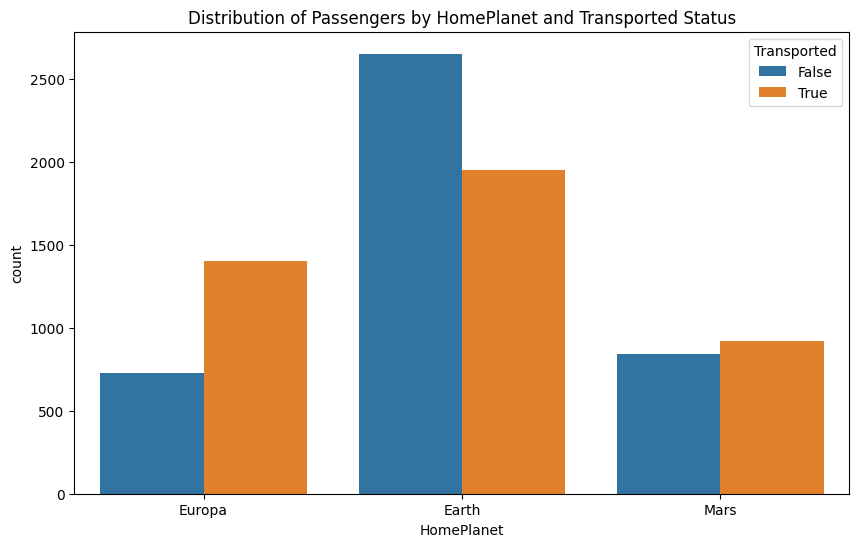

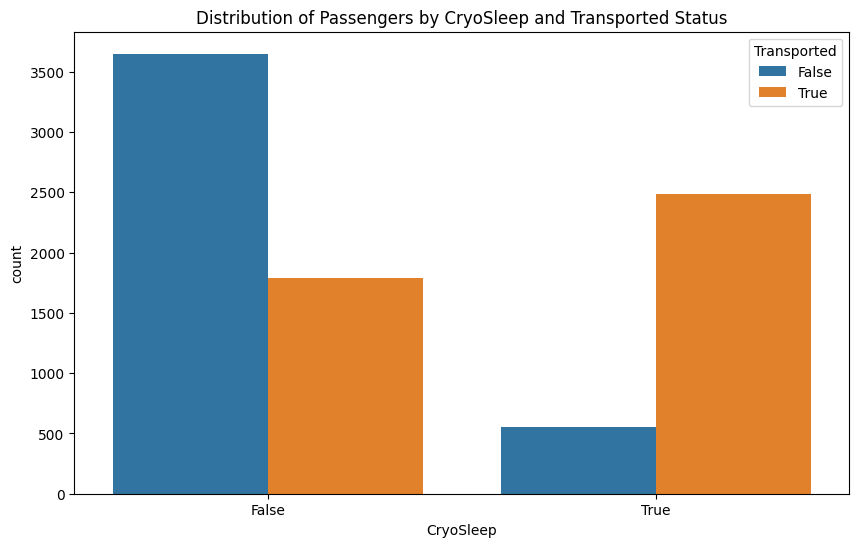

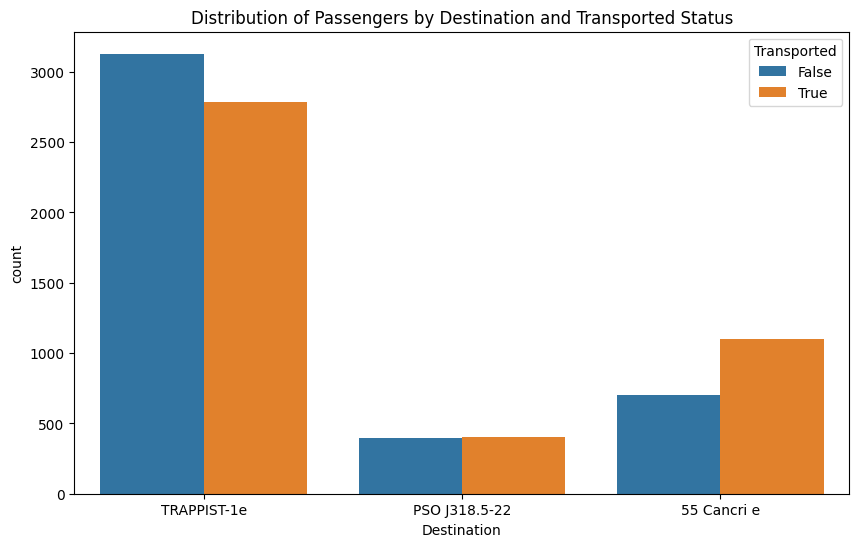

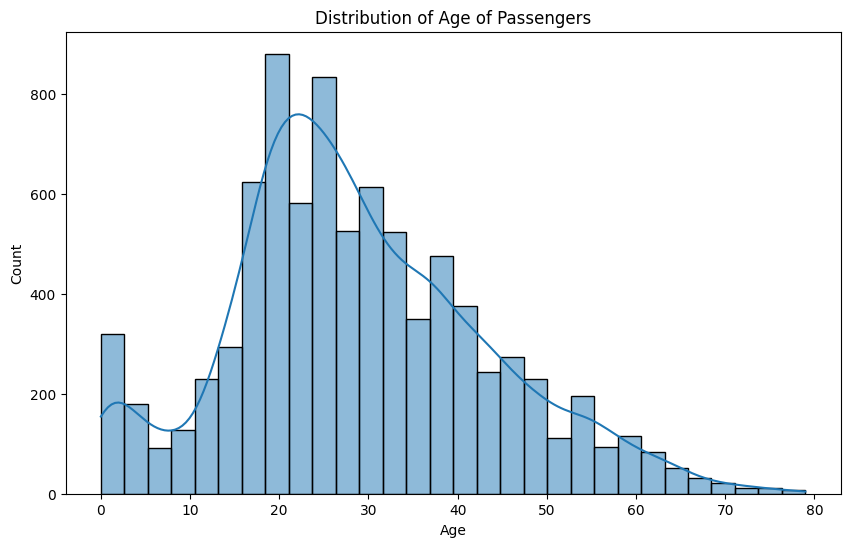

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a copy of the training dataset for visualization (including the split 'Cabin' columns)
viz_train_df = train_df.copy()

# Distribution of HomePlanet
plt.figure(figsize=(10, 6))
sns.countplot(x='HomePlanet', hue='Transported', data=viz_train_df)
plt.title('Distribution of Passengers by HomePlanet and Transported Status')
plt.show()

# Distribution of CryoSleep
plt.figure(figsize=(10, 6))
sns.countplot(x='CryoSleep', hue='Transported', data=viz_train_df)
plt.title('Distribution of Passengers by CryoSleep and Transported Status')
plt.show()

# Distribution of Destination
plt.figure(figsize=(10, 6))
sns.countplot(x='Destination', hue='Transported', data=viz_train_df)
plt.title('Distribution of Passengers by Destination and Transported Status')
plt.show()

# Distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(viz_train_df['Age'], bins=30, kde=True)
plt.title('Distribution of Age of Passengers')
plt.show()


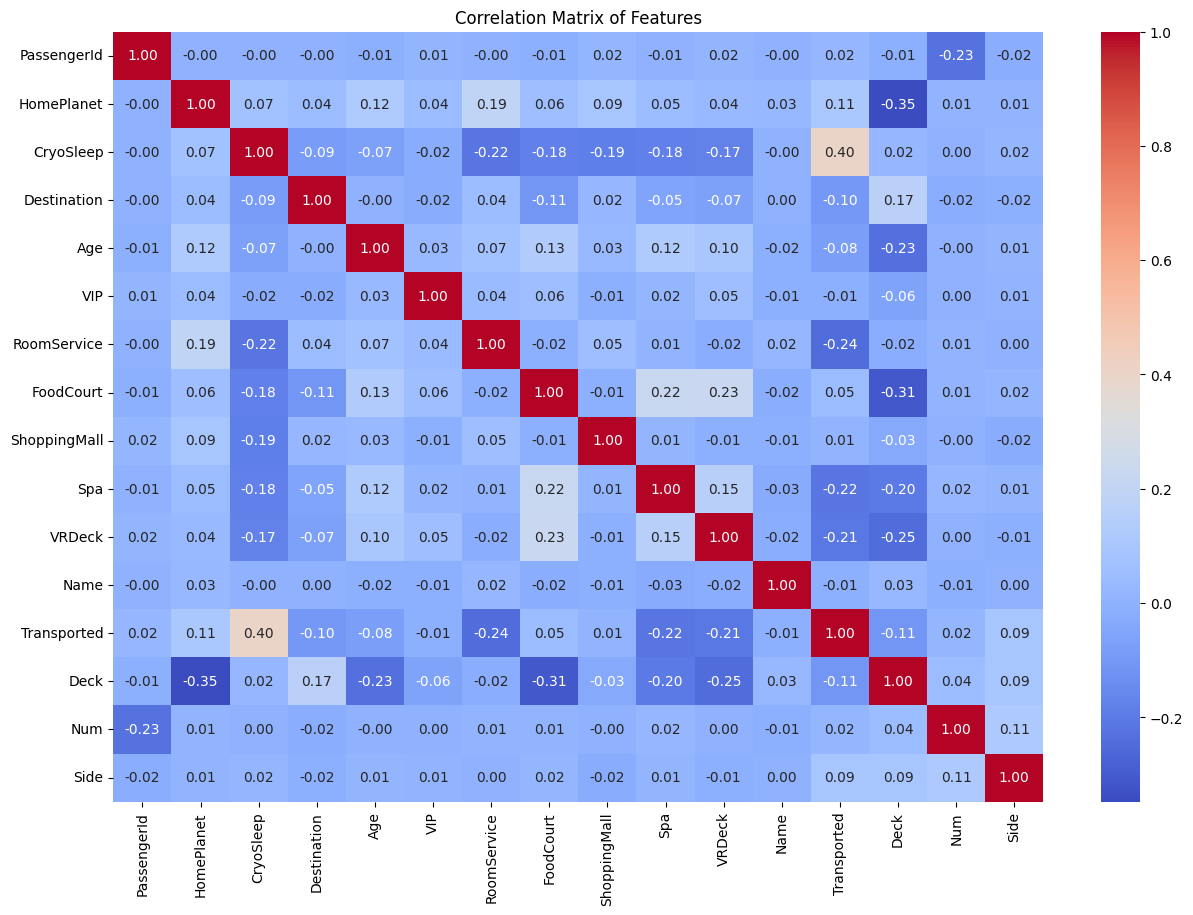

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Creating a copy of the dataset for correlation analysis
correlation_df = train_df.copy()

# Encoding categorical variables
label_encoders = {}
for column in correlation_df.select_dtypes(include=['object', 'bool']).columns:
    label_encoders[column] = LabelEncoder()
    correlation_df[column] = label_encoders[column].fit_transform(correlation_df[column])

# Computing the correlation matrix
correlation_matrix = correlation_df.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()


impute missing values and one-hot encoding

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identifying categorical and numerical columns

categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Pipeline for imputing and encoding categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline for imputing numerical columns
numerical_transformer = SimpleImputer(strategy='median')

# Combining transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Applying the transformations to the training data

X_train = preprocessor.fit_transform(train_df.drop(['PassengerId', 'Name', 'Transported'], axis=1))
y_train = train_df['Transported']

# Applying the same transformations to the test data (excluding target variable)
X_test = preprocessor.transform(test_df.drop(['PassengerId', 'Name'], axis=1))

categorical_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(input_features=categorical_cols)

# Combine categorical feature names with numerical feature names
all_feature_names = np.concatenate([numerical_cols, categorical_features])


# Checking the shape of the processed data
X_train.shape, X_test.shape, y_train.shape, cols.shape
print(all_feature_names)

['Age' 'RoomService' 'FoodCourt' 'ShoppingMall' 'Spa' 'VRDeck'
 'HomePlanet_Earth' 'HomePlanet_Europa' 'HomePlanet_Mars'
 'CryoSleep_False' 'CryoSleep_True' 'Destination_55 Cancri e'
 'Destination_PSO J318.5-22' 'Destination_TRAPPIST-1e' 'VIP_False'
 'VIP_True' 'Deck_A' 'Deck_B' 'Deck_C' 'Deck_D' 'Deck_E' 'Deck_F' 'Deck_G'
 'Deck_T' 'Side_P' 'Side_S']


# Random Forest Classifier

cross validation

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Initializing the Random Forest Classifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Performing cross-validation to evaluate the model
cv_scores = cross_val_score(random_forest_model, X_train, y_train, cv=5, scoring='accuracy')

# Calculating the average cross-validation score
average_cv_score = cv_scores.mean()

average_cv_score


0.7873005463902313

predict

In [ ]:
# Training the model on the entire training dataset
random_forest_model.fit(X_train, y_train)

# Making predictions on the test dataset
test_predictions = random_forest_model.predict(X_test)

# Preparing the submission file
submission_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Transported': test_predictions})
submission_df.head()

# Save the dataframe to a CSV file
submission_df.to_csv('submission.csv', index=False)

from google.colab import files
files.download('submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

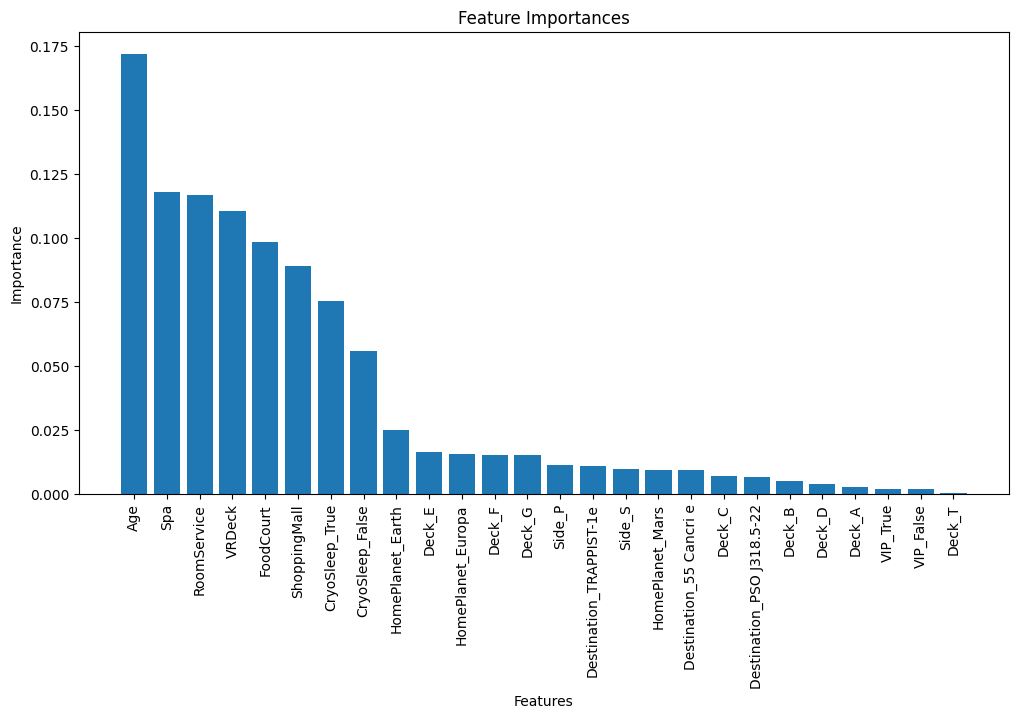

In [ ]:
import matplotlib.pyplot as plt

# Getting feature importances from the trained model
feature_importances = random_forest_model.feature_importances_

# Sorting the features by importance
indices = np.argsort(feature_importances)[::-1]

# Creating a bar plot for feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(len(all_feature_names)), feature_importances[indices], align="center")
plt.xticks(range(len(all_feature_names)), [all_feature_names[i] for i in indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


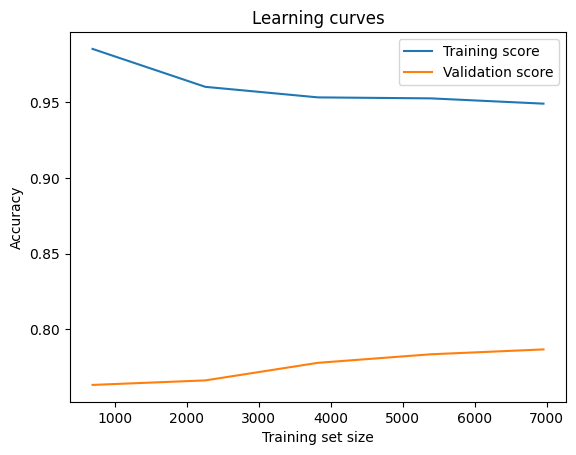

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    estimator = random_forest_model,
    X = X_train, # Your features
    y = y_train,   # Your target variable
    train_sizes = np.linspace(0.1, 1.0, 5),
    cv = 5,
    scoring = 'accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation score')
plt.ylabel('Accuracy')
plt.xlabel('Training set size')
plt.title('Learning curves')
plt.legend()
plt.show()


#Decision Tree

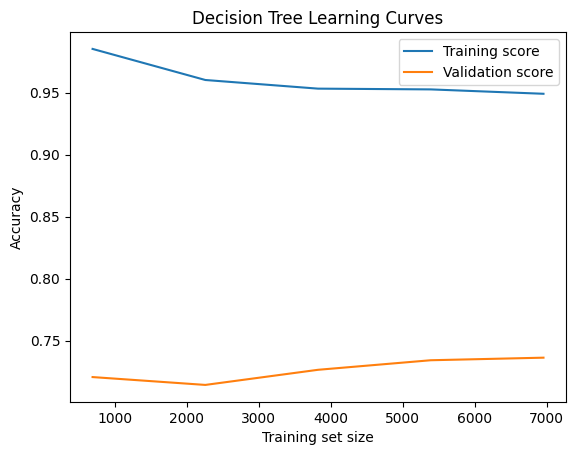

0.7363392847098745


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Create a DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Plot learning curves for the decision tree
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=decision_tree_model,
    X=X_train,  # Your feature matrix
    y=y_train,  # Your target variable
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=5,
    scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, validation_scores_mean, label='Validation score')
plt.ylabel('Accuracy')
plt.xlabel('Training set size')
plt.title('Decision Tree Learning Curves')
plt.legend()
plt.show()

# Train the decision tree model on the entire training dataset
decision_tree_model.fit(X_train, y_train)

# Make predictions on the test dataset
test_predictions = decision_tree_model.predict(X_test)

# Prepare the submission file
submission_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Transported': test_predictions})
submission_df.head()


# Performing cross-validation to evaluate the model
cv_scores = cross_val_score(decision_tree_model, X_train, y_train, cv=5, scoring='accuracy')

# Calculating the average cross-validation score
average_cv_score = cv_scores.mean()

print(average_cv_score)

# kNN


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

train_file_id = '1J6pVdmBbEN7kvAq6f36s9Nx7qFNVpjfD'
test_file_id = '1NnH_ZI6EbISZJO1YOLfmLs9ex11wO2AH'

train_download = drive.CreateFile({'id': train_file_id})
test_download = drive.CreateFile({'id': test_file_id})

# Download the file to a local disc
train_download.GetContentFile('train_file.csv')
test_download.GetContentFile('test_file.csv')


# Specify the data type for the problematic column (e.g., as 'str' if it should be a string)
# If you're not sure about the correct data type, you can use 'str' to read everything as strings and then process it later.
dtype_dict = {6: 'str'}

all_train_df = pd.read_csv("train_file.csv", dtype=dtype_dict, low_memory=False)
test_data = pd.read_csv("test_file.csv", dtype=dtype_dict, low_memory=False)

In [ ]:
all_columns = all_train_df.columns.tolist()
for i in all_columns:
        all_train_df[i].fillna(all_train_df[i].mode()[0], inplace=True)

In [ ]:
cabin_list = all_train_df["Cabin"].tolist()
deck = []
number = []
side = []
for i in cabin_list:
    a = i.split('/')
    deck.append(a[0])
    number.append(a[1])
    side.append(a[2])

all_train_df = all_train_df.drop(columns=["Cabin"])
all_train_df["deck"] = deck
all_train_df["number"] = number
all_train_df["side"] = side

print(all_train_df.columns.tolist())

['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported', 'deck', 'number', 'side']


In [ ]:
X = all_train_df.drop(columns=["Transported", "PassengerId", "Name"])
y = pd.DataFrame(all_train_df["Transported"])

dicrete_columns = ["HomePlanet", "CryoSleep", "Destination", "VIP", "deck", "side"]


print(X.columns.tolist())

for i in dicrete_columns:
    one_hot = pd.get_dummies(X[i])
    rename_dic = {}
    for j in one_hot.columns.values.tolist():
        rename_dic[j] = str(i)+"_"+str(j)
    one_hot = one_hot.rename(columns=rename_dic)
    X = X.drop(i, axis=1)
    X = X.join(one_hot)

print(X.columns.tolist())
print(len(X.columns.tolist()))
X.replace({True:1, False:0}, inplace=True)

['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'deck', 'number', 'side']
['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'number', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'CryoSleep_False', 'CryoSleep_True', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'VIP_False', 'VIP_True', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'deck_T', 'side_P', 'side_S']
27


<ipython-input-6-ee827cb95592>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = correlation_df.corr()


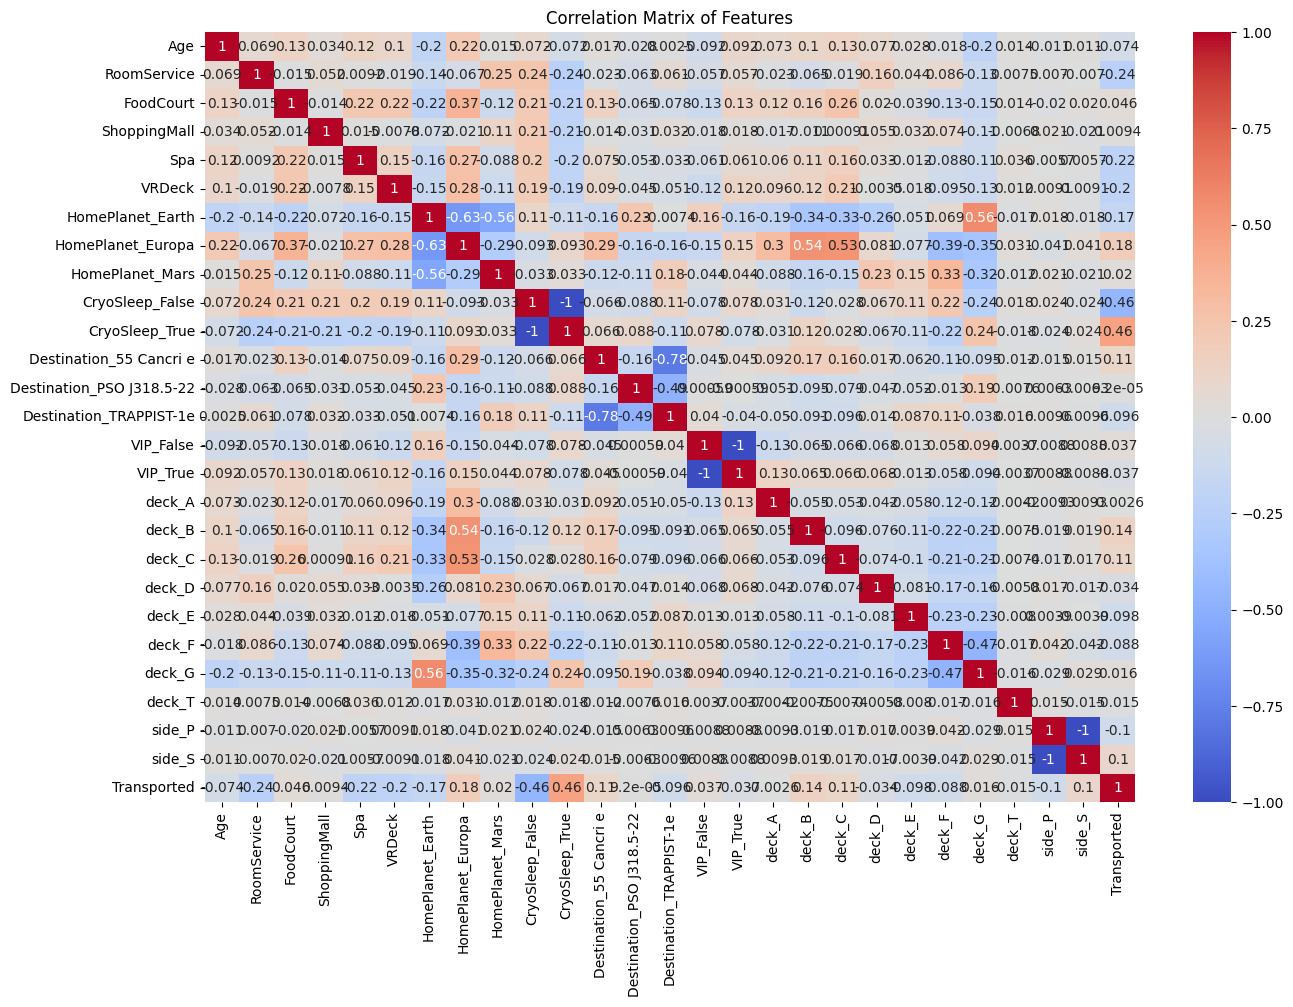

Age                         -0.074153
RoomService                 -0.241124
FoodCourt                    0.045583
ShoppingMall                 0.009391
Spa                         -0.218545
VRDeck                      -0.204874
HomePlanet_Earth            -0.168845
HomePlanet_Europa            0.176916
HomePlanet_Mars              0.019544
CryoSleep_False             -0.460132
CryoSleep_True               0.460132
Destination_55 Cancri e      0.108722
Destination_PSO J318.5-22    0.000092
Destination_TRAPPIST-1e     -0.096319
VIP_False                    0.037261
VIP_True                    -0.037261
deck_A                      -0.002623
deck_B                       0.144733
deck_C                       0.108193
deck_D                      -0.034046
deck_E                      -0.097965
deck_F                      -0.087753
deck_G                       0.015822
deck_T                      -0.014568
side_P                      -0.101397
side_S                       0.101397
Transported 

In [ ]:
correlation_df = pd.concat([X, y], axis=1)
correlation_matrix = correlation_df.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

print(correlation_matrix["Transported"])


In [ ]:
# kNN
kf = KFold(n_splits=5)

X = X.values
y = y.values



X = preprocessing.scale(X)

all_score = {}

for k in range(3, 22, 2):
    score = []

    for train_indices, validation_indices in kf.split(X):
        X_train, X_validation, y_train, y_validation = X[train_indices, :], X[validation_indices, :], y[train_indices], y[validation_indices]
        knnclf = KNeighborsClassifier(n_neighbors=k, algorithm="kd_tree")
        knnclf.fit(X_train, y_train.ravel())
        score.append(knnclf.score(X_validation, y_validation))

    all_score[k] = sum(score)/len(score)


In [ ]:
print(all_score)

print(max(all_score, key=all_score.get), all_score[max(all_score, key=all_score.get)])

{3: 0.7616487260710261, 5: 0.7722318356845694, 7: 0.7757974339444849, 9: 0.7744165363610557, 11: 0.7764862945848672, 13: 0.7767157162794114, 15: 0.7755654315040256, 17: 0.7770609406752687, 19: 0.7760262600822794, 21: 0.7744158746313338}
17 0.7770609406752687


# Logistic Regression

In [ ]:
#logistic regression
all_score = []
for train_indices, validation_indices in kf.split(X):
        X_train, X_validation, y_train, y_validation = X[train_indices, :], X[validation_indices, :], y[train_indices], y[validation_indices]
        LR = LogisticRegression(C=0.5, penalty="l2", solver="newton-cholesky")
        LR.fit(X_train, y_train.ravel())
        all_score.append(LR.score(X_validation, y_validation.ravel()))

print(all_score)
print(sum(all_score)/len(all_score))

[0.7763082231167338, 0.78205865439908, 0.7975848188614146, 0.7807825086306099, 0.7756041426927502]
0.7824676695401177


In [ ]:

test_data_df = test_data
passanger_id = test_data_df["PassengerId"]

print(test_data_df.isnull().sum())

all_columns = test_data_df.columns.tolist()

for i in all_columns:
        test_data_df[i].fillna(test_data_df[i].mode()[0], inplace=True)

print(test_data_df.isnull().sum())

cabin_list = test_data_df["Cabin"].tolist()
deck = []
number = []
side = []
for i in cabin_list:
    a = i.split('/')
    deck.append(a[0])
    number.append(a[1])
    side.append(a[2])

test_data_df = test_data_df.drop(columns=["Cabin"])
test_data_df["deck"] = deck
test_data_df["number"] = number
test_data_df["side"] = side

test_data_df = test_data_df.drop(columns=["PassengerId", "Name"])

dicrete_columns = ["HomePlanet", "CryoSleep", "Destination", "VIP", "deck", "side"]

print(test_data_df.columns.tolist())

for i in dicrete_columns:
    one_hot = pd.get_dummies(test_data_df[i])
    rename_dic = {}
    for j in one_hot.columns.values.tolist():
        rename_dic[j] = str(i)+"_"+str(j)
    one_hot = one_hot.rename(columns=rename_dic)
    test_data_df = test_data_df.drop(i, axis=1)
    test_data_df = test_data_df.join(one_hot)

print(test_data_df.columns.tolist())
test_data_df.replace({True:1, False:0}, inplace=True)

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64
PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
dtype: int64
['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'deck', 'number', 'side']
['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'number', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'CryoSleep_False', 'CryoSleep_True', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'VIP_False', 'VIP_True', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'd

In [ ]:
print(test_data_df.columns.tolist())
print(len(test_data_df.columns.tolist()))

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'number', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'CryoSleep_False', 'CryoSleep_True', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'VIP_False', 'VIP_True', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'deck_T', 'side_P', 'side_S']
27


In [ ]:
test_data_df = test_data_df.values
test_data_df = preprocessing.scale(test_data_df)


# knnclf = KNeighborsClassifier(n_neighbors=17, weights="distance", algorithm="kd_tree")
# knnclf.fit(X, y.ravel())
# predicted = knnclf.predict(test_data_df)

LR = LogisticRegression(C=0.5, penalty="l2", solver="newton-cholesky")
LR.fit(X, y.ravel())
predicted = LR.predict(test_data_df)

print(predicted)

[ True False  True ...  True  True  True]


In [ ]:
ans = pd.DataFrame(list(zip(passanger_id, predicted)), columns=["PassengerId", "Transported"])
ans.to_csv("ans.csv",index=False)

from google.colab import files
files.download('ans.csv')